# Titanic Challenge from Kaggle

## 1. Introduction

<div style="text-align: justify">The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, **killing 1502 out of 2224 passengers and crew**. This sensational tragedy shocked the international community and led to better safety regulations for ships.</div>

<div style="text-align: justify">One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as *women, children, and the upper-class.*</div>

<div style="text-align: justify">In this challenge, I try to complete the analysis of what sorts of people were likely to survive applying **machine learning** tools to predict which passengers survived the tragedy.</div>

#### Import libraries

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

from collections import Counter

"""
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')
"""

"\nfrom sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier\nfrom sklearn.discriminant_analysis import LinearDiscriminantAnalysis\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve\n\nsns.set(style='white', context='notebook', palette='deep')\n"

## 2. Load and check data

#### 2.1 Load data

In [23]:
##### Load train and Test set

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [25]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The **Survived** feature is the target variable. If the passenger survived, then *Survived* = 1. Otherwise, he or she died.

#### Data dictionary:
    - survival     Survival 	            0 = No, 1 = Yes
    - pclass       Ticket class 	        1 = 1st, 2 = 2nd, 3 = 3rd
    - sex          Sex 	
    - Age          Age in years 	
    - sibsp 	   # of siblings / spouses aboard the Titanic 	
    - parch 	   # of parents / children aboard the Titanic 	
    - ticket       Ticket number 	
    - fare         Passenger fare 	
    - cabin        Cabin number 	
    - embarked     Port of Embarkation      C = Cherbourg, Q = Queenstown, S = Southampton

#### Variable Notes:
**pclass**: A proxy for socio-economic status (SES)<br />
1st = Upper<br />
2nd = Middle<br />
3rd = Lower<br />

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way:<br />
*Sibling* = brother, sister, stepbrother, stepsister<br />
*Spouse* = husband, wife (mistresses and fiancés were ignored)<br />

**parch**: The dataset defines family relations in this way:<br />
*Parent* = mother, father<br />
*Child* = daughter, son, stepdaughter, stepson<br />
Some children travelled only with a nanny, therefore parch=0 for them.

#### 2.2 Outlier detection

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [4]:
# detect outliers from digital features 
outliers_to_drop = detect_outliers(train,2,["Pclass","Age","SibSp","Parch","Fare"])

In [5]:
train.loc[outliers_to_drop] # No outliers in Pclass, Age or Parch

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect *10 outliers*. The 28, 89 and 342 passenger have an high Ticket Fare. The 7 others have very high values of SibSP. Considering n=1, there would be 81 outliers.

In [6]:
len(detect_outliers(train,1,["Pclass","Age","SibSp","Parch","Fare"]))

81

In [7]:
# Drop outliers
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

#### 2.3 Joining train and test set

In [8]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
dataset =  pd.concat(objs=[train, test], axis=0).reset_index().drop('index',axis=1)

#### 2.4 Check for missing values

In [9]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values in dataset
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [10]:
#Check for Null values in train
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [11]:
#Feature data types
dataset.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object

In [12]:
#Summarize train dataset
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature Analysis

#### 3.1 Numerical Values

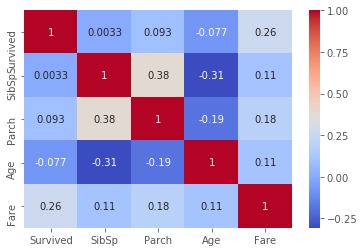

In [13]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, cmap = "coolwarm")

#### SibSp

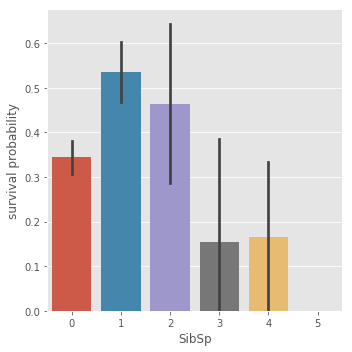

In [14]:
# Explore SibSp feature vs Survived
sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar",size = 5).set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive. Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive. We can consider a new feature describing these categories.

#### Parch

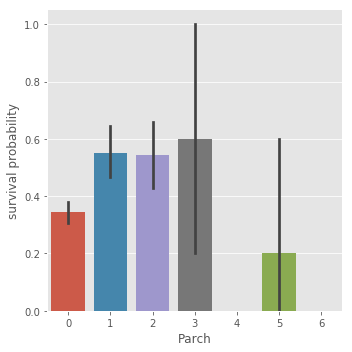

In [15]:
# Explore Parch feature vs Survived
sns.factorplot(x="Parch",y="Survived",data=train,kind="bar",size = 5).set_ylabels("survival probability")

#### Age

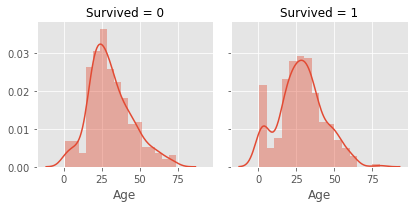

In [16]:
# Explore Age vs Survived
sns.FacetGrid(train, col='Survived').map(sns.distplot, "Age")

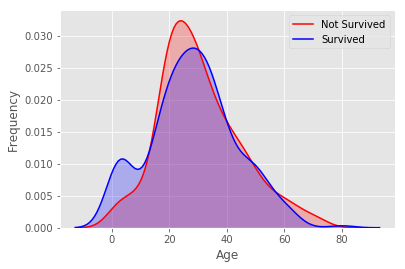

In [17]:
# Explore Age distibution 
g=sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red",shade = True)
g=sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue",shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g.legend(["Not Survived","Survived"])

So, even if **Age** is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

#### Fare

Since we have one missing value, we are going to fill it with the median value which will not have an important effect on the prediction.

In [18]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Not Survived Skew: 4.672917006976249
Survived Skew: 4.077138539816583


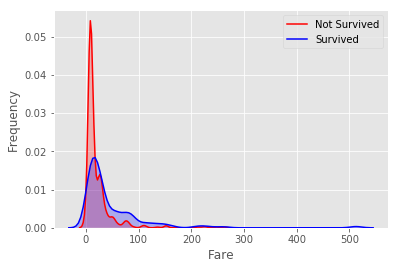

In [19]:
# Explore Fare distibution 
g = sns.kdeplot(train["Fare"][train["Survived"] == 0], color="Red", shade = True)
g = sns.kdeplot(train["Fare"][train["Survived"] == 1], ax =g, color="Blue", shade= True)
g.set_xlabel("Fare")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])
print('Not Survived Skew: {}'.format(train["Fare"][train["Survived"] == 0].skew()))
print('Survived Skew: {}'.format(train["Fare"][train["Survived"] == 1].skew()))

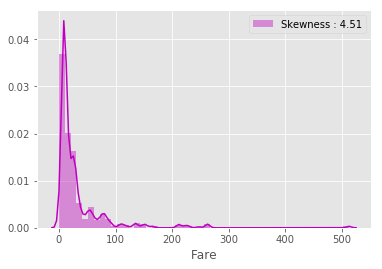

In [20]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend()

Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled. In this case, it is better to transform it with the log function to reduce this skew.

In [21]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

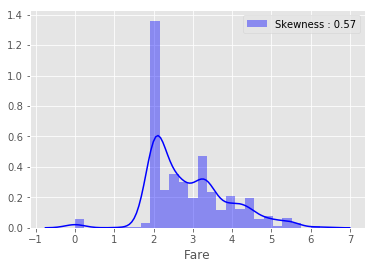

In [22]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend()

#### 3.2 Categorical Values

#### Sex